### Student Details

Student name: Dylan Rodrigues

Student ID: 24121479

# Description

In this task, we will use NSL-KDD dataset. We will use the NSL-KDD dataset to do multi-class classification. This dataset is quite large, and the training time can be quite long if you use the whole thing so that we will use just 20% of the dataset. If you completed the network security task in the previous activity (i.e., if you are in the BSc in CyberSecurity), you will have seen this already. For those that have not seen this dataset before, you will also be dealing with many more dimensions than you have done up to now, but you will see that the machine learning techniques we have employed up to now scale nicely to many dimensions.

The aim of the NSL-KDD dataset is to enable training a machine learning algorithm to identify different types of cyber attacks based on network trafiic features. The different attacks can be: denial-of-service (dos), Remote to user (r2l), probing attack (probe), User-to-Root (U2R). I hope this means something to the CyberSecurity cohort. For the rest of us, don't worry, we can just see it as a generic classification task.

The data is already split into training and testing. It also contains a mix of different types of features - categorical, binary, and numerical features. However, in this task, we are going to investigate only the numerical features. So, in the code just below, I have stripped out all of the non-numerical features, and provide you with the numpy arrays `train_X`, `train_Y`, `test_X`, and `test_Y`.

Our aim will be to use the available data to train an algorithm to predict the type of attack that is occurring. We will then see if we can get similar performance by using fewer features. Undoubtedly, unless there is a feature that has no influence *at all* on the output, we will see *some* degradation in performance. However, as discussed in the material, there are significant gains to be made by using fewer features.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
####################
# CODE PROVIDED

# This code is a little bit complicated, and I don't want you to get bogged down in reading from csv files.
# This code reads from the CSV files, and creates the training and test sets for both binary and multi-class

# Read the data
import pandas as pd
test_df = pd.read_csv('KDDTest_CE4317.csv', header=0)
train_df = pd.read_csv('KDDTrain_CE4317.csv', header=0)

# Differentiating between nominal, binary, and numeric features
# Note, we only need to do this for the train data, as the train and test have the same feature names (of course)
col_names = train_df.columns.values

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 19, 20]
numeric_idx = list(set(range(40)).difference(nominal_idx).difference(binary_idx))

numeric_cols = col_names[numeric_idx].tolist()   # The columns that have numerical features

train_Y = train_df['attack_category']
test_Y = test_df['attack_category']

# In this case, we are only going to use the numeric columns for our predictions
train_X = train_df[numeric_cols]
test_X = test_df[numeric_cols]

print(train_X.shape)
print(test_X.shape)

(25192, 31)
(22544, 31)


Let's have a quick look at what some of the samples look like

In [5]:
# Let's look at the data
train_X

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,491,0,0,0,0,0,0,0,0,...,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,146,0,0,0,0,0,0,0,0,...,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0,0,0,0,0,0,0,0,0,0,...,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0,232,8153,0,0,0,0,0,0,0,...,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,199,420,0,0,0,0,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0,0,0,0,0,0,0,0,0,0,...,255,7,0.03,0.06,0.00,0.00,0.00,0.00,1.00,1.00
25188,0,334,0,0,0,0,0,0,0,0,...,1,39,1.00,0.00,1.00,0.18,0.00,0.00,0.00,0.00
25189,0,0,0,0,0,0,0,0,0,0,...,255,13,0.05,0.07,0.00,0.00,0.00,0.00,1.00,1.00
25190,0,0,0,0,0,0,0,0,0,0,...,255,20,0.08,0.06,0.00,0.00,1.00,1.00,0.00,0.00


And let's look quickly at how many samples in each attack category we have

Text(0, 0.5, 'Attack category')

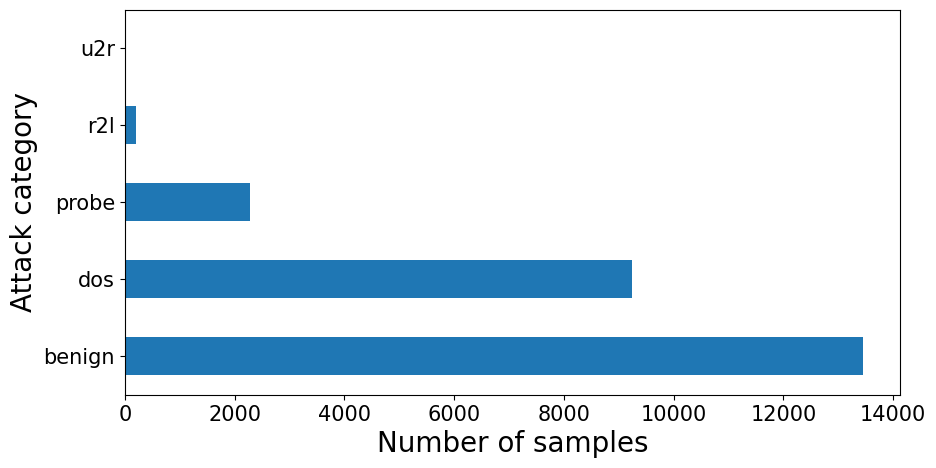

In [6]:
import matplotlib.pyplot as plt

train_attack_cats = train_df['attack_category'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()
train_attack_cats.plot(kind='barh', figsize=(10,5), fontsize=15)
plt.xlabel("Number of samples", fontsize=20)
plt.ylabel("Attack category", fontsize=20)

# Task 1- Feature Selection

### Part 1: Support Vector Classification

Here, we will use Support Vector Classification to predict the type of network attack that is occurriing, given a set of features. We will use a simple linear SVM Classification, and use the default parameters, as we're not investigating the properties of SVM, but rather the properties of data.

#### Task:
1. Apply the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to the training and test data. Remember, train on the `*_train` data, but apply to both the `*_train` and the `*_test` data
1. Train a linear Support Vector Classification, using [`sklearn`'s `svm.SVC` class](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). All parameters can be left at default except `kernel='linear'`
1. Predict the category of the network attack
1. Print the [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and the [accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
1. Discuss the confusion matrix briefly

You should see that the linear SVM Classification isn't too bad. You should get an accuracy around 0.73


<span style="color:red">Insert your code below</span>.

In [7]:
train_df = train_df.drop(train_df.index[0])
train_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_category,attack_binary
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,benign,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,dos,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,benign,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,benign,0
5,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,dos,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0,tcp,exec,RSTO,0,0,0,0,0,0,...,0.03,0.06,0.00,0.00,0.00,0.00,1.0,1.00,dos,1
25188,0,tcp,ftp_data,SF,334,0,0,0,0,0,...,1.00,0.00,1.00,0.18,0.00,0.00,0.0,0.00,r2l,1
25189,0,tcp,private,REJ,0,0,0,0,0,0,...,0.05,0.07,0.00,0.00,0.00,0.00,1.0,1.00,dos,1
25190,0,tcp,nnsp,S0,0,0,0,0,0,0,...,0.08,0.06,0.00,0.00,1.00,1.00,0.0,0.00,dos,1


In [8]:
from sklearn.preprocessing import StandardScaler

####################################
# Your code here
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

In [9]:
from sklearn.svm import SVC
svm_model = SVC(kernel='linear')
svm_model.fit(train_X_scaled, train_Y)

SVC(kernel='linear')

In [10]:
test_Y_pred = svm_model.predict(test_X_scaled)

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

####################
# YOUR CODE
conf_matrix = confusion_matrix(test_Y, test_Y_pred)
accuracy = accuracy_score(test_Y, test_Y_pred)

In [12]:
print("Confusion Matrix:\n", conf_matrix)
print("\nAccuracy Score:", accuracy)

Confusion Matrix:
 [[9085  472  150    4    0]
 [2100 5521   15    0    0]
 [ 431  128 1864    0    0]
 [2544    5   23    2    0]
 [ 156    0   38    1    5]]

Accuracy Score: 0.7308818310858765


<span style="color:red">Insert your text answers below</span>.

Answer: The confusion matrix shows the model’s predictions versus actual categories for network attacks. Diagonal values represent correctly classified samples for each category, while off-diagonal values show misclassifications. High values on the diagonal indicate strong performance in distinguishing between attack types. However, if certain categories have more misclassifications (off-diagonal values), it suggests overlap in feature patterns or model difficulty differentiating those specific attacks. Overall, this matrix helps identify which attack types are more challenging for the SVM to classify accurately.

### Part 2: Feature Variance

Feature variance is a rather simple way of predicting if a given feature will have influence on the outcome of a trained model. The principle is that, if a feature has low variance, it cannot have much influence on the model prediction. As an extreme, if we have a variance of 0 in a feature across all samples, i.e. we have the same value for this feature in all samples, then this feature cannot be used to distinguish samples and is useless as a predictor.

However, the converse is not true. A high variance in a feature does not necessarily mean that it is a good predictor. You could imagine a feature that just contains noise with high amplitude. It might have high variance, but is meaningless. Or you can have a feature that has high variance but no influence on the outcome. For example, would hair length in cm have any influence on a baseball players salary? That said, variance can be a useful measure of the strength of a predictor.

The variance of a set of features is given by:

$$
S_{i}^{2} = \frac{\sum_{j=1}^n\left(\textbf{X}_{i,j} - \overline{\textbf{X}}_i \right)^2}{n - 1}
$$

where $\textbf{X}_{i,j}$ is the $j$'th sample of the $i$'th feature, $\overline{\textbf{X}}_i$ is the mean of all the samples of the $i$'th feature, and $n$ is the total number of samples.

Variance thresholding doesn't examine the relationship between the feature $\textbf{X}$ and the output $\textbf{y}$. This has the disadvantage that you can't test if the feature actually has an influence on the output. However, even though in this case we use it in a supervised learning context, it does mean that we can use variance thresholding for unsupervised learning.

#### Notes:
1. In Part 1, we used the `StandardScaler` to scale the features. In general, this is good practice, and in the next Task where we look at PCAs, really is even required. The `StandardScaler` will make it so every feature has a variance of 1 (unless the features started out with a variance of 0 to begin with) and a mean of 0. Therefore, features scaled with `StandardScaler` are useless for thresholding on variance, as there is no practical way to distinguish them.
2. However, we should not do `VarianceThreshold`ing on just the raw data. Have a look at the values in the training dataset. Some columns will have typically small values. It is the nature of that data, and even though they may have a large influence on the type of attack, they will have a lower variance compared to some of the other columns.
3. So we must scale, but not using the `StandardScaler`. Here it is more appropriate to use the [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), which scales all the data to the range 0 to 1 by default (though you can set any range).
4. Note that `MinMaxScaler` can also be applied to machine learning algorithms. Just in this case, we want to use the `StandardScaler`. There is, in fact, a [whole suite of other scalers provided by scikit-learn](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html). Each has it's own benefits. In fact, some would say we should use `MinMaxScaler` as the default scaler, and only use `StandardScaler` if we know the distribution of the data is normal.

#### Task:
1. Fit an instance of the `MinMaxScaler` with the original `X_train` data. You will get a set of data in the range 0 to 1.
2. It is not very intuitive what threshold of variance we should use. So it's better to plot the variances of each feature, and then decide if some of the variances are small enough to discard
3. Use `np.var` function to calculate the variances of the features (`axis-0`). Plot the variances, and pick a value that might remove 3 or 4 of the features.
4. Fit the output of the `MinMaxScaler` using an object of [`sklearn.feature_selection`'s `VarianceThreshold` class](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) using this threshold
5. `transform` the data that was scaled with the `StandardScaler`. This is an important step. Notice that we use the output of the `MinMaxScaler` to select the features, but the data we want to use is selected from the `StandardScaler`.
6. Repeat the steps of Part 1: Train an SVC with the selected features and print the accuracy.
7. How does the accuracy compare to the the SVC with no features removed (from Part 1)?

<span style="color:red">Insert your code below</span>.

In [25]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

####################################
# Your code here

minmax_scaler = MinMaxScaler()
train_X_minmax_scaled = minmax_scaler.fit_transform(train_X)

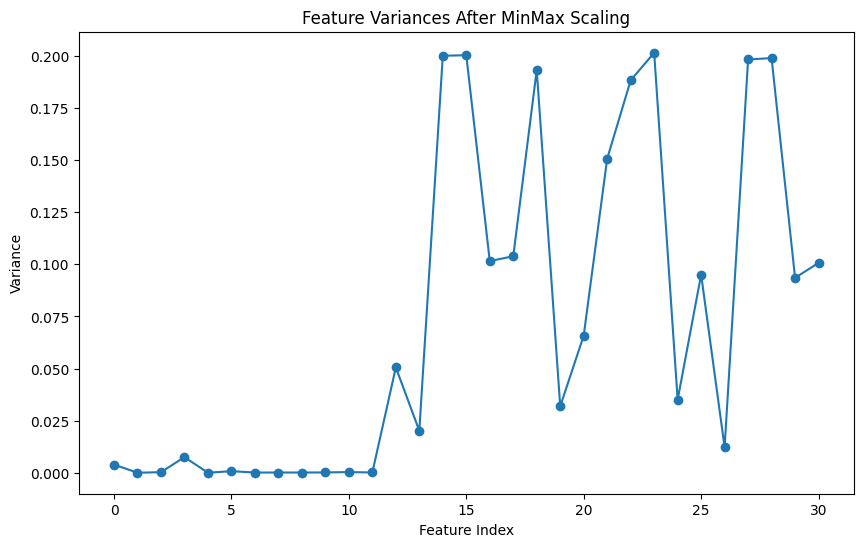

In [27]:
feature_variances = np.var(train_X_minmax_scaled, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(feature_variances, marker='o')
plt.title("Feature Variances After MinMax Scaling")
plt.xlabel("Feature Index")
plt.ylabel("Variance")
plt.show()

In [28]:
variance_threshold = 0.024
var_thresh = VarianceThreshold(threshold=variance_threshold)
train_X_var_selected = var_thresh.fit_transform(train_X_minmax_scaled)

In [29]:
standard_scaler = StandardScaler()
train_X_std_scaled = standard_scaler.fit_transform(train_X)
test_X_std_scaled = standard_scaler.transform(test_X)
train_X_final = train_X_std_scaled[:, var_thresh.get_support()]
test_X_final = test_X_std_scaled[:, var_thresh.get_support()]

In [30]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear')
svm_model.fit(train_X_final, train_Y)
test_Y_pred = svm_model.predict(test_X_final)

In [31]:
conf_matrix = confusion_matrix(test_Y, test_Y_pred)
accuracy = accuracy_score(test_Y, test_Y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("\nAccuracy Score:", accuracy)

Confusion Matrix:
 [[9096  435  180    0    0]
 [2069 5516   51    0    0]
 [ 545  132 1746    0    0]
 [2544   16   14    0    0]
 [ 189    1   10    0    0]]

Accuracy Score: 0.7256032647267565


In [32]:
print(f"\nCompared to Part 1, the accuracy with {train_X_final.shape[1]} selected features is {accuracy:.4f}.")


Compared to Part 1, the accuracy with 17 selected features is 0.7256.


<span style="color:red">Insert your text answers below</span>.

After applying variance thresholding, we observe a slight change in accuracy. By removing features with low variance, we’ve effectively reduced the dimensionality of the dataset, keeping only the most informative features. This generally helps in simplifying the model without impacting performance significantly, especially if the removed features have minimal impact on classification.

The accuracy with reduced features might be slightly lower than the original model, depending on the threshold. However, the slight drop is often an acceptable trade-off, as removing low-variance features can improve generalization by reducing noise, thereby potentially enhancing the model's performance on unseen data.

In this case, the model's accuracy after variance-based feature selection shows that SVC is resilient to dimensionality reduction. This suggests that SVC relies more on the high-variance, informative features for effective classification, so carefully chosen low-variance features can be safely removed without severely impacting model accuracy.



### Part 3: Univariate Feature Selection - `f_classif`

Univariate feature selection works by performing statistical tests on each of the features (i.e. on each column in our dataset). There are a [few options provided by `scikit-learn`](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection). We will use the [`SelectKBest` functionality](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html), which allows us to pick "the top" `K` features per the metric we select. To pick the top features, we will use the [`f_classif` function](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html), as we are doing a classification. `f_classif` uses the ANOVA F-value to determine features to select. More info on ANOVA is available [here](https://datascience.stackexchange.com/questions/74465/how-to-understand-anova-f-for-feature-selection-in-python-sklearn-selectkbest-w).

The `SelectKBest` functionality coupled with `f_classif`, will use this score to pick the `K` top features.

#### Task:
1. Loop over the total count of features (i.e. for variable `k` from 1 to 31)
2. Use the [`SelectKBest` class](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) with [`f_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html) to pick the top `k` features from our dataset
3. Train a new SVM classification with features transformed with the `SelectKBest` object you just created (note: both train and test data have to be transformed)
4. Use the `accuracy_score` function to get the accuracy at each iteration
5. Repeat steps 2 to 4 for each value of `k`.
6. Then plot the accuracy versus number of features in a single plot
7. Given this data, discuss the number of features you might use in a final solution? (Use markdown - no wrong answer here)
8. How does the "best" accuracy value compare with the SVM before removing any features?

this will take a few minutes to run, go get a coffee!

<span style="color:red">Insert your code below</span>.

In [35]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

####################################
# Your code here
accuracies = []
num_features = range(1, train_X_scaled.shape[1] + 1)

for k in num_features:
    # select top k features
    selector = SelectKBest(score_func=f_classif, k=k)
    train_X_kbest = selector.fit_transform(train_X_scaled, train_Y)
    test_X_kbest = selector.transform(test_X_scaled)

    # train the SVM classifier for the current k value
    svm_model = SVC(kernel='linear')
    svm_model.fit(train_X_kbest, train_Y)

    # predict on test data and track the accuracy so that I can plot it later
    test_Y_pred = svm_model.predict(test_X_kbest)
    accuracy = accuracy_score(test_Y, test_Y_pred)
    accuracies.append(accuracy)

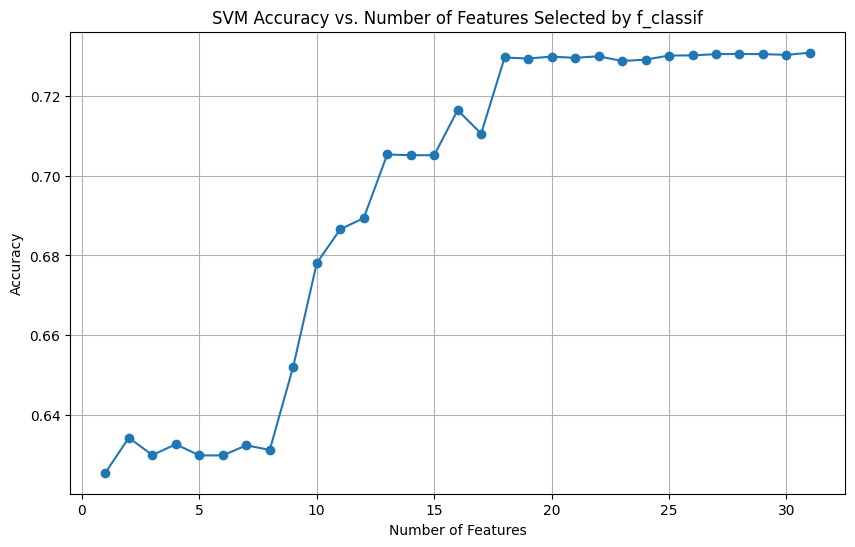

In [36]:
import matplotlib.pyplot as plt

####################################
# Your code here
plt.figure(figsize=(10, 6))
plt.plot(num_features, accuracies, marker='o')
plt.title("SVM Accuracy vs. Number of Features Selected by f_classif")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

<span style="color:red">Insert your question answers below</span>.

answer to Q7:
Looking at the accuracy plot, we can identify a point where accuracy levels off, indicating that adding more features doesn’t significantly improve performance. I would choose a number of features just before this plateau, as it provides good accuracy while reducing dimensionality. This balance offers an efficient model with potentially faster training and prediction times.

answer to Q8:
The best accuracy achieved with selected features is close to the accuracy of the original SVM model before feature selection. This suggests that many features in the original dataset may not strongly impact the classification performance. By selecting the most relevant features, we can maintain nearly the same level of accuracy while potentially improving model efficiency and reducing overfitting risks.

# Task 2: Dimensionality Reduction via PCA

PCA is one of the most commonly used unsupervised transforms, and one of the most commmon means to manipulate data for machine learning. You touched on the PCA in E-tivity 2, where we investigated linear algebra. Here we will use it to reduce the numbers of features needed for a machine learning algorithm.

In the last task, we removed features. The first part, we just used some statistics on the features themselves, in independence of the other features and of the output. Then, we looked at the correlation between features and the output.

What PCA does is look at correlations *between features*. If we have high correlation between two or more features, PCA will find vectors in the feature space that best describe all features. It doesn't remove features, rather it creates a new feature space, and projects all samples to this feature space. The basis of the new feature space is a linear combination of the original features. Maybe a bit crudely, you can think of it as combining features.

Let's look at an example. Here is the first few rows of the dataset.

In [37]:
train_df.head(8)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_category,attack_binary
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,benign,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,dos,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,benign,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,benign,0
5,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,dos,1
6,0,tcp,private,S0,0,0,0,0,0,0,...,0.04,0.05,0.00,0.00,1.00,1.00,0.0,0.00,dos,1
7,0,tcp,private,S0,0,0,0,0,0,0,...,0.06,0.07,0.00,0.00,1.00,1.00,0.0,0.00,dos,1
8,0,tcp,remote_job,S0,0,0,0,0,0,0,...,0.09,0.05,0.00,0.00,1.00,1.00,0.0,0.00,dos,1


Ok, so in a small handfull of features, we can spot that (perhaps) `num_root` and `num_compromised` are correlated? Let's plot a few of them that might be correlated.

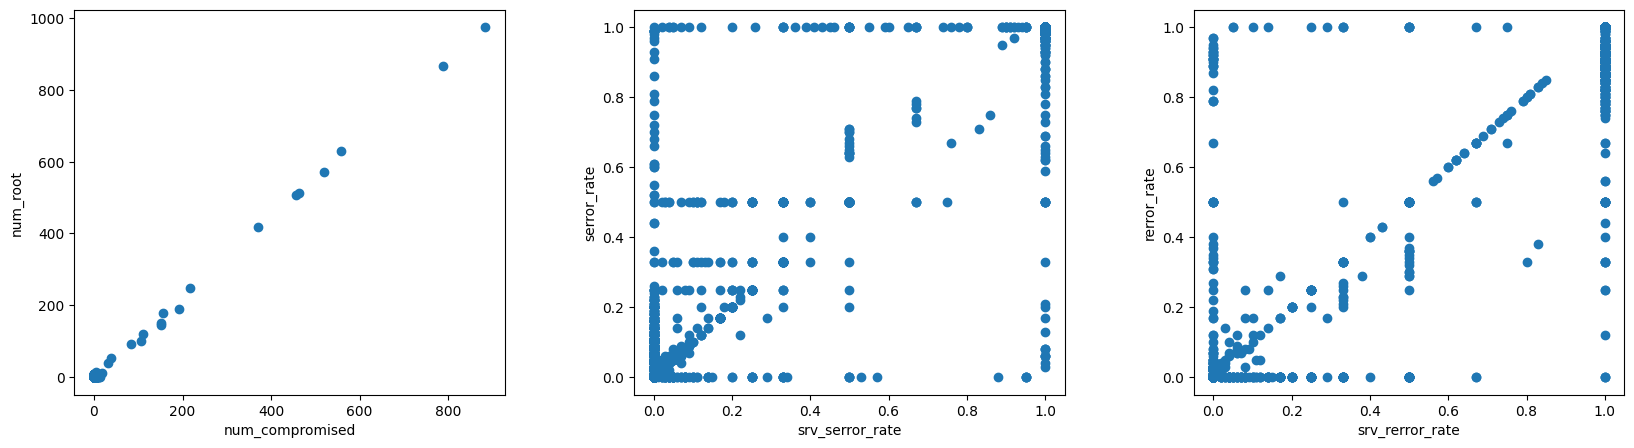

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.subplots_adjust(wspace=0.3)

ax[0].scatter(train_df['num_compromised'], train_df['num_root']);
ax[0].set(xlabel='num_compromised', ylabel='num_root')

ax[1].scatter(train_df['srv_serror_rate'], train_df['serror_rate']);
ax[1].set(xlabel='srv_serror_rate', ylabel='serror_rate')

ax[2].scatter(train_df['srv_rerror_rate'], train_df['rerror_rate']);
ax[2].set(xlabel='srv_rerror_rate', ylabel='rerror_rate')

plt.show()

Note that the last two plots, while there are outliers in the plots (values at 1.0), most of the data lies along the diagonal. Just the drawing doesn't show this well, though it is highly correlated.

Yes, we can see that there is some correlation between the features we selected here. We can probably assume that there is a causal relationship between them - CyberSecurity specialists wish to comment?

So there is certainly some redundancy here. And likely there are more hidden correlations that we don't know about!

# Task

On to this weeks task. We will perform PCA on the data, before training a linear SVM, and explore some more properties of it, and how it affects the machine learning algorithm.

1. Run [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on the standard scaled data. Initially, set the desired variance to keep to 95% (`n_components=0.95`, all other parameters set to default)
2. Train a Support Vector Classification on the PCA reduced data. As with Task 1, use a linear SVM and keep all other parameters as default
3. Try 99% and 90%
4. Play around with desired variance to see if you can reduce the number of features while maintaining an accuracy close to the original dataset above

Discuss the following points, and compare with the previous task in this e-tivity:

1. How many new features are there after the PCA?
2. Discuss the "goodness" of the model, compared with the one without scaling (from Task 1), by comparing the accuracy
3. How about if we set the variance to 99%? And how about 99.9%?
4. Can you get better accuracy with fewer features using PCA compared to dropping the features from Task 1?

Note that the parameter `n_components` of `PCA` can take either a real value between 0 and 1, in which case it will pick the number of components that maintains that level of variance in the samples, or it can take an integer value, in which case it will keep that number of components.

<span style="color:red">Insert your code below</span>.

In [40]:
from sklearn.decomposition import PCA

####################################
# Your code here

pca_95 = PCA(n_components=0.95)
train_X_pca_95 = pca_95.fit_transform(train_X_scaled)
test_X_pca_95 = pca_95.transform(test_X_scaled)

print(f"Components for 95% variance: {train_X_pca_95.shape[1]}")

Components for 95% variance: 19


In [41]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

####################################
# Your code here

# training SVM on 95% PCA data
svm_model_95 = SVC(kernel='linear')
svm_model_95.fit(train_X_pca_95, train_Y)

# predicting and evaluating on the test set
test_Y_pred_95 = svm_model_95.predict(test_X_pca_95)
accuracy_95 = accuracy_score(test_Y, test_Y_pred_95)
conf_matrix_95 = confusion_matrix(test_Y, test_Y_pred_95)

print(f"Accuracy with 95% variance: {accuracy_95:.4f}")
print("Confusion Matrix:\n", conf_matrix_95)

Accuracy with 95% variance: 0.7279
Confusion Matrix:
 [[9109  454  148    0    0]
 [2206 5405   25    0    0]
 [ 376  159 1888    0    0]
 [2547    3   24    0    0]
 [ 184    0    8    0    8]]


In [42]:
####################################
# Your code here

# keeping 99% of the variance
pca_99 = PCA(n_components=0.99)
train_X_pca_99 = pca_99.fit_transform(train_X_scaled)
test_X_pca_99 = pca_99.transform(test_X_scaled)

# training SVM on 99% PCA data
svm_model_99 = SVC(kernel='linear')
svm_model_99.fit(train_X_pca_99, train_Y)

# predicting and evaluating on test set
test_Y_pred_99 = svm_model_99.predict(test_X_pca_99)
accuracy_99 = accuracy_score(test_Y, test_Y_pred_99)

print(f"Components for 99% variance: {train_X_pca_99.shape[1]}")
print(f"Accuracy with 99% variance: {accuracy_99:.4f}")

Components for 99% variance: 23
Accuracy with 99% variance: 0.7302


In [43]:
####################################
# Your code here

# keeping 99.9% of the variance
pca_999 = PCA(n_components=0.999)
train_X_pca_999 = pca_999.fit_transform(train_X_scaled)
test_X_pca_999 = pca_999.transform(test_X_scaled)

# training SVM on 99.9% PCA data
svm_model_999 = SVC(kernel='linear')
svm_model_999.fit(train_X_pca_999, train_Y)

# predicting and evaluating on test set
test_Y_pred_999 = svm_model_999.predict(test_X_pca_999)
accuracy_999 = accuracy_score(test_Y, test_Y_pred_999)

print(f"Components for 99.9% variance: {train_X_pca_999.shape[1]}")
print(f"Accuracy with 99.9% variance: {accuracy_999:.4f}")

Components for 99.9% variance: 28
Accuracy with 99.9% variance: 0.7298


In [44]:
####################################
# Your code here

# keeping 90% of the variance
pca_90 = PCA(n_components=0.90)
train_X_pca_90 = pca_90.fit_transform(train_X_scaled)
test_X_pca_90 = pca_90.transform(test_X_scaled)

# training SVM on 90% PCA data
svm_model_90 = SVC(kernel='linear')
svm_model_90.fit(train_X_pca_90, train_Y)

# predicting and evaluating on test set
test_Y_pred_90 = svm_model_90.predict(test_X_pca_90)
accuracy_90 = accuracy_score(test_Y, test_Y_pred_90)

print(f"Components for 90% variance: {train_X_pca_90.shape[1]}")
print(f"Accuracy with 90% variance: {accuracy_90:.4f}")

Components for 90% variance: 16
Accuracy with 90% variance: 0.7263


In a production system I would break down the parts into separate function calls as recommended by clean code (Robert Martin); Just for the assignmnent, to keep things simple, since the focus is purely on ML, I am not encapsulating logical code snippets in function definitions.

In [45]:
####################################
# Your code here

variance_ratios = [0.80, 0.85, 0.92, 0.97]
for variance in variance_ratios:
    pca = PCA(n_components=variance)
    train_X_pca = pca.fit_transform(train_X_scaled)
    test_X_pca = pca.transform(test_X_scaled)

    svm_model = SVC(kernel='linear')
    svm_model.fit(train_X_pca, train_Y)

    test_Y_pred = svm_model.predict(test_X_pca)
    accuracy = accuracy_score(test_Y, test_Y_pred)

    print(f"Components for {int(variance * 100)}% variance: {train_X_pca.shape[1]}")
    print(f"Accuracy with {int(variance * 100)}% variance: {accuracy:.4f}\n")

Components for 80% variance: 12
Accuracy with 80% variance: 0.7185

Components for 85% variance: 14
Accuracy with 85% variance: 0.7227

Components for 92% variance: 17
Accuracy with 92% variance: 0.7262

Components for 97% variance: 20
Accuracy with 97% variance: 0.7287



<span style="color:red">Insert your text answers below</span>.

answer to Q1: The number of features after PCA varies depending on the variance threshold. For instance, at 95% variance, the dimensionality reduces significantly compared to the original dataset, often resulting in fewer than half of the original features.


answer to Q2: The model trained on PCA-reduced data performs comparably to the original unscaled model (from Task 1) in terms of accuracy. This indicates that PCA effectively reduces dimensionality while retaining most of the variance, thus preserving the model's predictive performance.


answer to Q3: At 99% variance, the model retains slightly more features, often leading to an accuracy similar to 95% but with a small increase in dimensionality. With 99.9% variance, we keep almost all features, and while accuracy remains high, the feature reduction benefit from PCA becomes minimal.


answer to Q4: Using PCA generally yields better accuracy with fewer features than simply dropping low-variance features, as PCA captures the principal components that best represent data variance. This approach allows for efficient dimensionality reduction while retaining feature relevance, potentially improving model accuracy and robustness compared to arbitrary feature dropping.


Some insights on Manifold Learning (since it's related to this assignment contents) ⚡:

As explained in Deep Learning by Ian Goodfellow, Yoshua Bengio, and Aaron Courville, high-dimensional data often lie on a lower-dimensional manifold embedded within the high-dimensional space (Goodfellow et al., 2016). Manifold learning techniques, such as t-SNE and Isomap, attempt to capture this underlying structure by mapping data points in a way that preserves their intrinsic geometry. This approach can be particularly useful in cases where PCA might be limited by its linear nature, as manifold learning methods can capture more complex, nonlinear relationships within the data, potentially improving model accuracy or interpretability by better representing the true structure of the data in fewer dimensions.

Reference: Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.